# 02 — Baseline Training (Feature Extraction)

**Objective:** Train a baseline age regression model using transfer learning (ResNet50) in **feature extraction** mode (frozen backbone).

**Pipeline highlights:**
- Reproducible train/val/test splits (stratified by age bins)
- `tf.data` input pipeline (decode → resize → normalize → batch → prefetch)
- Baseline training with callbacks
- Artifacts saved (splits, history, metrics, figures, model checkpoint)


In [1]:
from pathlib import Path
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from src.config import load_config
from src.data import load_labels, validate_schema, make_splits, save_splits, build_dataset
from src.model import build_resnet50_regressor
from src.train import make_callbacks, compile_model, train_stage_1, save_test_metrics
from src.utils import plot_history_mae

PROJECT_ROOT = Path.cwd().parents[0]
CFG_PATH = PROJECT_ROOT / "configs/default.yaml"

cfg = load_config(CFG_PATH).raw
cfg


2026-01-19 22:09:35.858917: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-19 22:09:35.952049: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-19 22:09:37.953646: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


{'project': {'name': 'age-prediction',
  'seed': 42,
  'device': 'gpu',
  'output_dir': 'reports'},
 'data': {'csv_path': 'data/labels.csv',
  'images_dir': 'data/images',
  'filename_col': 'file_name',
  'target_col': 'real_age',
  'image_size': [224, 224],
  'channels': 3,
  'batch_size': 32,
  'val_size': 0.15,
  'test_size': 0.15,
  'stratify_bins': 10,
  'cache': False,
  'prefetch': True},
 'model': {'backbone': 'ResNet50',
  'weights': 'imagenet',
  'pooling': 'avg',
  'dropout': 0.2,
  'dense_units': 128,
  'l2': 0.0},
 'train': {'epochs_stage1': 8,
  'epochs_stage2': 12,
  'lr_stage1': 0.001,
  'lr_stage2': 5e-05,
  'fine_tune_N_last': 30,
  'optimizer': 'adam',
  'loss': 'mae',
  'metrics': ['mae']},
 'callbacks': {'early_stopping_patience': 5,
  'reduce_lr_patience': 2,
  'reduce_lr_factor': 0.2,
  'min_lr': 1e-07},
 'artifacts': {'save_best': True,
  'best_model_path': 'models/best.keras',
  'history_path': 'reports/metrics/history.csv',
  'metrics_path': 'reports/metrics/t

## Reproducibility

- Splits use a fixed random seed.
- Split CSVs are saved as artifacts under `reports/metrics/`.
- Training logs and metrics are saved for traceability.


In [2]:
# Load labels + schema validation

filename_col = cfg['data']['filename_col']
target_col = cfg['data']['target_col']

df = load_labels(PROJECT_ROOT/ cfg['data']['csv_path'])
validate_schema(df, filename_col, target_col)

print(f"Rows: {len(df)}")

display(df.head())


Rows: 7591


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


## Train/Val/Test splits

We stratify by **age bins** to keep the distribution stable across splits.
Artifacts saved:
- `split_train.csv`, `split_val.csv`, `split_test.csv`
- `split_summary.json`


In [3]:
RANDOM_STATE = int(cfg["project"]["seed"])

train_df, val_df, test_df = make_splits(df,
                                        filename_col=filename_col,
                                        target_col=target_col,
                                        val_size=float(cfg["data"]["val_size"]),
                                        test_size=float(cfg["data"]["test_size"]),
                                        seed=RANDOM_STATE,
                                        stratify_bins=int(cfg["data"]["stratify_bins"])
                                        )


metrics_dir = PROJECT_ROOT / "reports"/ "metrics"

split_paths = save_splits(train_df,
                          val_df,
                          test_df,
                          metrics_dir,
                          filename_col=filename_col,
                          target_col=target_col)

display(split_paths)

{'train_csv': '/home/carlos/projects/age-estimation-resnet50/reports/metrics/split_train.csv',
 'val_csv': '/home/carlos/projects/age-estimation-resnet50/reports/metrics/split_val.csv',
 'test_csv': '/home/carlos/projects/age-estimation-resnet50/reports/metrics/split_test.csv',
 'summary_json': '/home/carlos/projects/age-estimation-resnet50/reports/metrics/split_summary.json'}

In [4]:
# Quick distribution sanity check
for name, df in zip(["train_df", "val_df", "test_df"], [train_df, val_df, test_df]):
    print(f"{name} - rows: {len(df)}, min_age: {df[target_col].min()}, max_age: {df[target_col].max()}, p50_age: {df[target_col].median():.2f}, p90_age: {df[target_col].quantile(0.9):.2f}")

    

train_df - rows: 5313, min_age: 1, max_age: 100, p50_age: 29.00, p90_age: 54.00
val_df - rows: 1139, min_age: 1, max_age: 96, p50_age: 29.00, p90_age: 54.20
test_df - rows: 1139, min_age: 1, max_age: 97, p50_age: 28.00, p90_age: 54.00


## `tf.data` pipeline

We build datasets for train/val/test:
- decode JPEG → resize → normalize to [0, 1]
- shuffle (train only)
- batch + prefetch


In [5]:
img_dir = PROJECT_ROOT / cfg['data']["images_dir"]
img_size = tuple(cfg['data']['image_size'])
batch_size = int(cfg['data']['batch_size'])


train_ds = build_dataset(
    train_df,
    images_dir=img_dir,
    filename_col=filename_col,
    target_col=target_col,
    img_size=img_size,
    batch_size=batch_size,
    training=True,
    seed=RANDOM_STATE,
    cache=bool(cfg["data"].get("cache", False)),
    prefetch=bool(cfg["data"].get("prefetch", True)),
)

val_ds = build_dataset(
    val_df,
    images_dir=img_dir,
    filename_col=filename_col,
    target_col=target_col,
    img_size=img_size,
    batch_size=batch_size,
    training=False,
    seed=RANDOM_STATE,
    cache=bool(cfg["data"].get("cache", False)),
    prefetch=bool(cfg["data"].get("prefetch", True)),
)

test_ds = build_dataset(
    test_df,
    images_dir=img_dir,
    filename_col=filename_col,
    target_col=target_col,
    img_size=img_size,
    batch_size=batch_size,
    training=False,
    seed=RANDOM_STATE,
    cache=False,
    prefetch=True,
)

I0000 00:00:1768882180.434698   54517 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9704 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


In [6]:
# Quick sanity check for a batch
x, y = next(iter(train_ds))
print("x shape:", x.shape)
print("y shape:", y.shape)
print("x range:", float(tf.reduce_min(x)), float(tf.reduce_max(x)))
print("y range:", float(tf.reduce_min(y)), float(tf.reduce_max(y)))


x shape: (32, 224, 224, 3)
y shape: (32,)
x range: 0.0 1.0
y range: 4.0 68.0


## Baseline model (ResNet50 frozen)

We train a small regression head on top of a frozen ResNet50 backbone.
Metric: **MAE (years)**.


In [7]:
dropout = float(cfg["train"].get("dropout", 0.2))
dense_units = int(cfg["train"].get("dense_units", 128))

model = build_resnet50_regressor(
    img_size=img_size,
    dropout=dropout,
    dense_units=dense_units,
)

model.summary()


Model: "resnet50_age_regressor"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ multiply[0][0]    │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ multiply[0][0]    │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 2048)      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ resnet50[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    262,272 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age (Dense)         │ (None, 1)         │        129 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [8]:
# Compile model

lr_stage_1 = float(cfg['train']['lr_stage1'])
compile_model(model, lr=lr_stage_1)

## Callbacks + artifacts

Artifacts:

- Best model checkpoint → `models/baseline_best.keras`
- Training history CSV → `reports/metrics/baseline_history.csv`
- Final test metrics JSON → `reports/metrics/baseline_test_metrics.json`
- Training curve figure → `reports/figures/baseline_mae_curve.png`

In [9]:
models_dir = PROJECT_ROOT / "models"
fig_dir = PROJECT_ROOT / "reports" / "figures"
fig_dir.mkdir(parents=True, exist_ok=True)

callbacks = make_callbacks(models_dir=models_dir, metrics_dir=metrics_dir, monitor="val_mae")
callbacks

In [10]:
# Stage 1 training
epochs_stage_1 = int(cfg['train']['epochs_stage1'])

history_stage_1 = train_stage_1(
    model,
    train_ds,
    val_ds,
    epochs=epochs_stage_1,
    callbacks=callbacks
)

Epoch 1/8


2026-01-19 22:09:51.927242: I external/local_xla/xla/service/service.cc:163] XLA service 0x797ab8003a60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-01-19 22:09:51.927330: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2026-01-19 22:09:52.144174: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-19 22:09:54.985086: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91800
2026-01-19 22:09:55.398436: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-01-19 22:09:57.187104: I e


Epoch 1: val_mae improved from None to 10.16228, saving model to /home/carlos/projects/age-estimation-resnet50/models/baseline_best.keras

Epoch 1: finished saving model to /home/carlos/projects/age-estimation-resnet50/models/baseline_best.keras
167/167 - 66s - 394ms/step - loss: 11.7793 - mae: 11.7793 - val_loss: 10.1623 - val_mae: 10.1623 - learning_rate: 0.0010
Epoch 2/8

Epoch 2: val_mae improved from 10.16228 to 9.53913, saving model to /home/carlos/projects/age-estimation-resnet50/models/baseline_best.keras

Epoch 2: finished saving model to /home/carlos/projects/age-estimation-resnet50/models/baseline_best.keras
167/167 - 25s - 149ms/step - loss: 10.1703 - mae: 10.1703 - val_loss: 9.5391 - val_mae: 9.5391 - learning_rate: 0.0010
Epoch 3/8

Epoch 3: val_mae improved from 9.53913 to 9.52149, saving model to /home/carlos/projects/age-estimation-resnet50/models/baseline_best.keras

Epoch 3: finished saving model to /home/carlos/projects/age-estimation-resnet50/models/baseline_best.

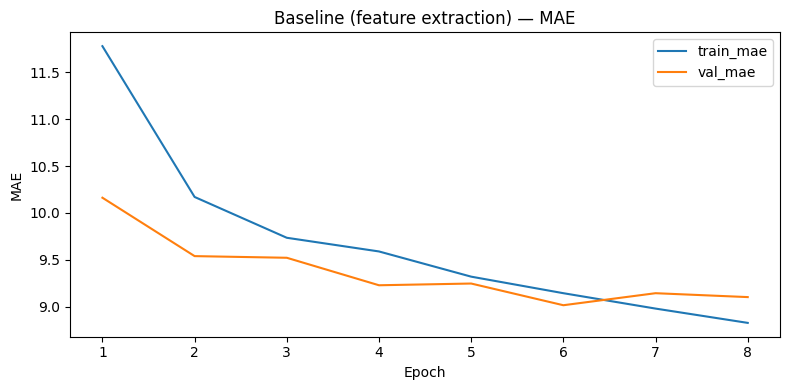

In [11]:
# Save plots of training history
plot_history_mae(
    history_stage_1,
    out_path=fig_dir / "baseline_mae_curve.png"
)

In [12]:
# Evaluate on test set and save metrics

test_loss, test_mae = model.evaluate(test_ds, verbose=0)
print("Test MAE:", test_mae)

metrics = {
    "stage": "baseline_feature_extraction",
    "test_mae": float(test_mae),
    "image_size": list(img_size),
    "batch_size": int(batch_size),
    "lr_stage1": float(lr_stage_1),
    "dropout": float(dropout),
    "dense_units": int(dense_units),
    "seed": int(RANDOM_STATE),
}

save_test_metrics(metrics, metrics_dir / "baseline_test_metrics.json")
metrics

Test MAE: 9.046701431274414


{'stage': 'baseline_feature_extraction',
 'test_mae': 9.046701431274414,
 'image_size': [224, 224],
 'batch_size': 32,
 'lr_stage1': 0.001,
 'dropout': 0.2,
 'dense_units': 128,
 'seed': 42}

## Next steps (Notebook 03)

- Fine-tune: unfreeze last `N` layers with a smaller LR.
- Keep BatchNorm frozen for stability (common practice with small batch sizes).
- Evaluate again on the test set.
- Error analysis: MAE by age bins + inspect worst predictions.